In [62]:
import torch ## main pytorch library, gives access to tensors, random generators, utils like data loaders, etc.
import torch.nn as nn ## neural network stuff like layers
import torch.nn.functional as F ## functions used in nn like activation functions, loss functions, drop functions, etc.
import torch.optim as optim ## optimizers

import torchvision ## library related to image analysis including ready datasets and trained models
import torchvision.transforms as transforms ## modules help with image data preprocessing such as transfromations

import matplotlib.pyplot as plt
import seaborn as sns # type: ignore
sns.set()

import numpy as np

torch.manual_seed(42)

### Load Dataset
* Remember, despite providing the transforms as a parameter when preparing the dataset, it won't apply the transforms functions until you use dataloader to load the data.
    * here a data pipeline is created through which the data will flow and multiple transforms will be applied.
However, until torch.utils.data.DataLoader is called, transformations on the data won't be applied

In [63]:
train_batch_size = 5
test_batch_size = 1000
# specify the transforms
train_transforms = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize(0.13, 0.31)
                                    ])

# prepare the dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=train_transforms)
# load the dataset
indices = torch.arange(100)
import torch.utils.data as data_utils
trainset = data_utils.Subset(trainset, indices)
from torch.utils.data import DataLoader
trainloader = DataLoader(trainset, batch_size=train_batch_size, shuffle=True, num_workers=4)
# explore the loaded dataset
images, labels = next(iter(trainloader))
print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(images.min(), images.max()))
print('Mean Pixel Value: {} \nPixel Values Std: {}'.format(images.float().mean(), images.float().std()))

# Create test set and define test dataloader
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=train_transforms)
testloader = DataLoader(testset, batch_size=test_batch_size, shuffle=True, num_workers=4)


Min Pixel Value: -0.4193548262119293 
Max Pixel Value: 2.8064515590667725
Mean Pixel Value: 0.07877343893051147 
Pixel Values Std: 1.0597584247589111


In [64]:
len(trainloader)

20

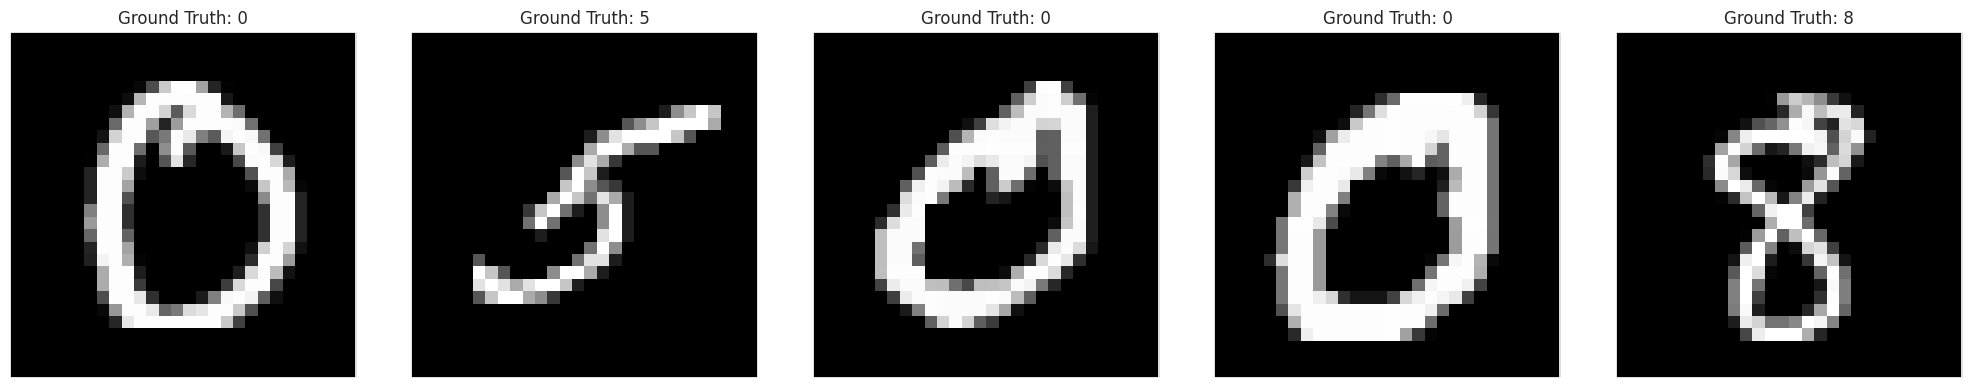

In [65]:
fig = plt.figure(figsize=(20,16))
for i in range(5):
  plt.subplot(4,5,i+1)
  plt.tight_layout()
  plt.imshow(images[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(labels[i]))
  plt.xticks([])
  plt.yticks([])
fig;

### Build the Neural Network Model
* nn.Module or nn.Sequential can be used similarly
    * as explained [here](https://discuss.pytorch.org/t/differences-between-writing-models-with-nn-sequential-vs-creating-a-class/17470):
        * You can use whatever fits your use case.
        * While some people like to use the nn.Sequential approach a lot, I usually just use it for small sub-modules and like to define my model in a functional way, i.e. derive from nn.Module and write the forward method myself.
        * This approach gives you more flexibility in my opinion, since you are able to easily create skip connections etc.
        * On the other hand if you just want to stack layers together, nn.Sequential is totally fine.
    * example of nn.Sequential
        * `net = nn.Sequential(
      nn.Linear(3, 4),
      nn.Sigmoid(),
      nn.Linear(4, 1),
      nn.Sigmoid()
      ).to(device)`
___
* The nn.Module is a base class for all neural network modules in PyTorch.
* when calling init of super, in previous versions of python, one had to specify two arguments subclass name and self
    * `super(SubclassName, self).__init__()`

In [66]:
def set_device():
    device = torch.device('cpu')
    if torch.cuda.is_available():
        device = torch.device('cuda')
    return device

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # define the layers
        self.activation = F.relu
        self.out_activation = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(p=0.2)
        self.to(device=set_device())
        self.layer1 = nn.Linear(28 * 28 * 1, 512)
        self.layer2 = nn.Linear(512, 256)
        self.layer3 = nn.Linear(256, 128)
        self.layer4 = nn.Linear(128, 64)
        self.layer5 = nn.Linear(64, 32)
        self.layer6 = nn.Linear(32, 16)
        self.output = nn.Linear(16, 10)
    
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.activation(self.layer1(x))
        # x = self.dropout(x)
        # print(x.shape)
        x = self.activation(self.layer2(x))
        # x = self.dropout(x)
        # print(x.shape)
        x = self.activation(self.layer3(x))
        # x = self.dropout(x)
        # print(x.shape)
        x = self.activation(self.layer4(x))
        # x = self.dropout(x)
        # print(x.shape)
        x = self.activation(self.layer5(x))
        # x = self.dropout(x)
        # print(x.shape)
        x = self.activation(self.layer6(x))
        # x = self.dropout(x)
        # print(x.shape)
        x = self.out_activation(self.output(x))
        # x = self.output2(x)
        return x

# Instantiate the model
model = Net()
# print(model)
# model.to(device=set_device())

# torch.Size([250, 512])
# torch.Size([250, 256])
# torch.Size([250, 128])
# torch.Size([250, 64])
# torch.Size([250, 32])
# torch.Size([250, 16])

### define the optimizers and loss function

In [67]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [68]:
n_epochs = 5
train_batch_losses = []
train_epoch_losses = []
predictions = []


In [69]:
model.train()
for epoch_i in range(n_epochs):
    batch_loss_sum = 0
    for batch_i, (input, target) in enumerate(trainloader):
        # making a pridiction in forward pass
        y_hat = model(input)
        # calculating the loss between original and predicted data points
        loss = criterion(y_hat, target)
        # sum the losses
        current_batch_loss= loss.item()
        batch_loss_sum += current_batch_loss
        # store loss into list
        train_batch_losses.append(current_batch_loss)
        # zeroing gradients after each iteration
        optimizer.zero_grad()
        # backward pass for computing the gradients of the loss w.r.t to learnable parameters
        loss.backward()
        # updateing the parameters after each iteration
        optimizer.step()
        
    # store batch id
    train_epoch_losses.append(batch_loss_sum/len(trainloader))
    print(f'Epoch: {epoch_i+1}, Loss: {train_epoch_losses[-1]}')
        # self.layer1 = nn.Linear(780, 512)
        # self.layer2 = nn.Linear(512, 256)
        # self.layer3 = nn.Linear(256, 128)
        # self.layer4 = nn.Linear(128, 64)
        # self.layer5 = nn.Linear(64, 32)
        # self.layer6 = nn.Linear(32, 16)

Epoch: 1, Loss: 2.300906240940094
Epoch: 2, Loss: 2.3002033591270448
Epoch: 3, Loss: 2.2993290185928346
Epoch: 4, Loss: 2.2977528095245363
Epoch: 5, Loss: 2.2945481181144713


In [70]:
train_epoch_losses2 = []
for i in range(5):
    # for sample_i, (input, target) in enumerate(trainloader):
    for w in range (240):
        train_epoch_losses2.append(train_epoch_losses[i])
    # break


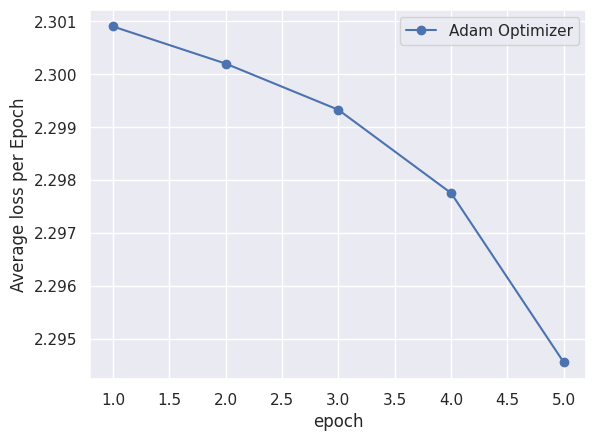

In [71]:

# plt.plot(train_batch_losses, label = "Adam Optimizer")
# plt.plot(train_epoch_losses2, marker="_", label = "Adam Optimizer")
plt.plot(range(1,n_epochs+1), train_epoch_losses, marker="o", label = "Adam Optimizer")
plt.xlabel('epoch')
plt.ylabel('Average loss per Epoch')
plt.legend()
plt.show()

In [72]:
len(train_batch_losses) # epochs*batch_count

100

In [77]:
# sum=0
# for sample_i, (input, target) in enumerate(trainloader):
#     print(target)
#     # break


# it contains the result for the last batch (batch of 5 samples)
# the output of final layer was 16
print(y_hat.shape) 
print(target)
print((y_hat[0]))


torch.Size([5, 10])
tensor([4, 0, 4, 4, 5])
tensor([0.0915, 0.1004, 0.1030, 0.1338, 0.0943, 0.0710, 0.1350, 0.0950, 0.0871,
        0.0888], grad_fn=<SelectBackward0>)


In [74]:
# Importing Libraries
import torch
import torch.nn as nn
# Using Softmax() function
a = nn.Softmax(dim=1)
# Describing a variable
input = torch.randn(4, 5)
# Declaring the output
output = a(input)
# Print the output
print(output)

tensor([[0.1738, 0.1141, 0.1949, 0.1627, 0.3544],
        [0.2976, 0.1580, 0.1899, 0.3035, 0.0509],
        [0.0130, 0.5464, 0.0443, 0.3677, 0.0286],
        [0.0377, 0.0262, 0.2600, 0.0168, 0.6594]])


In [75]:
sum(output[:,3])

tensor(0.8508)